In [100]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# So code is automatically reloaded when saved in different modules

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
import os
import pickle
import numpy as np
import tensorflow as tf
# from scipy import stats
import tensorflow as tf
# from sklearn.metrics import roc_auc_score
# import sklearn.metrics
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
import time
import logging
import sys
import time
from datetime import datetime
import csv
from collections import Counter, OrderedDict, defaultdict
import sys
import pprint
sys.path.append('src/taggerSystem/')
from my_data_util import load_and_preprocess_data, load_embeddings, ModelHelper
logger = logging.getLogger("hw3.q2")
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)

## File Paths


In [84]:
# data_train = "data/icd9NotesDataTable_train.csv"
# data_valid = "data/icd9NotesDataTable_valid.csv"
data_train = "data/smallIcd9NotesDataTable_train.csv"
data_valid = "data/smallIcd9NotesDataTable_valid.csv"
vocab = "src/taggerSystem/data_hw3_delete/vocab.txt"
wordVecs = "src/taggerSystem/data_hw3_delete/wordVectors.txt"
output_path = 'results/{}/{:%Y%m%d_%H%M%S}/".format(self.cell, datetime.now())'
log_output = output_path + "log"
START_TOKEN = "<s>"
END_TOKEN = "</s>"
NUM = "NNNUMMM"
UNK = "UUUNKKK"
EMBED_SIZE = 50

## Extract Data and Word Embeddings
You'll probably only need to work with xDev, yDev and xTrain, yTrain. The X matrices hold all word IDs in the order they appear in the note. yDev is a matrix of indicator vectors for icd9 presence

In [96]:
helper, train, dev, train_raw, dev_raw, xTrain, yTrain, xDev, yDev = load_and_preprocess_data(
    data_train = data_train, data_valid = data_valid)
embeddings = load_embeddings(vocab, wordVecs, helper)
helper.save(output_path)# token2id and max length saved to output_path
handler = logging.FileHandler(log_output)
handler.setLevel(logging.DEBUG)
handler.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s: %(message)s'))
logging.getLogger().addHandler(handler)

INFO:Loading training data...
INFO:Done. Read 7 notes
INFO:Loading dev data...
INFO:Done. Read 7 notes
INFO:Total read time 0.011189
INFO:Built dictionary for 11 features.
INFO:There are a total of 6 ICD codes
INFO:Initialized embeddings.


In [47]:
overWrite = input()
# Never overwrite unless you've loaded the correct yDev and xDev. Should only be run
# when on Azure with full data set
if overWrite == 'yes':
    print('overwriting xDev and yDev')
    np.save('results/yDev.npy',yDev)
    np.save('results/xDev.npy', xDev)
else:
    print('not overwriting xDev and yDev. You probably do not want this anyway')

no
not overwriting xDev and yDev. You probably do not want this anyway


In [109]:
yDev = np.load('results/yDev.npy')

In [89]:
print('Max note length %d'%(helper.max_length))
print('Number of Icd9 codes %d'%(helper.n_labels))
print('icd9 present')
print('xDev shape: nObs = %d, nWords = %d'%(xDev.shape))
print('yDev shape: nObs = %d, nClasses = %d'%(yDev.shape))
print('xTrain shape: nObs = %d, nWords = %d'%(xTrain.shape))
print('yTrain shape: nObs = %d, nClasses = %d'%(yTrain.shape))
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(helper.icdDict)

Max note length 4
Number of Icd9 codes 6
icd9 present
xDev shape: nObs = 7, nWords = 4
yDev shape: nObs = 7, nClasses = 6
xTrain shape: nObs = 7, nWords = 4
yTrain shape: nObs = 7, nClasses = 6
{'123': 5, '18': 4, '4240': 0, '45': 2, '456': 1, '486': 3}


## Hyperparameters

In [57]:
learning_rate = 0.001
training_epochs = 100
batch_size = 1
total_batches = (xTrain.shape[0]//batch_size)
print('Total number of batches per epoch %d'%(total_batches))
n_input = 1
n_steps = 10
n_hidden = 30
n_classes = helper.n_labels

Total number of batches per epoch 7


## Placeholders

In [73]:
tf.reset_default_graph()
x = tf.placeholder(tf.int32, shape= (None, helper.max_length))
yTruth = tf.placeholder(tf.int32, shape = (None, helper.n_labels))
y_steps = tf.placeholder(tf.int32, shape = (None, helper.n_labels))# not sure what this is

## Helper Functions

In [74]:
def LSTM(x, weight, bias):
    cell = tf.contrib.rnn.BasicLSTMCell(n_hidden,state_is_tuple = True)
    print(type(cell))
    print(cell)
    print(type(x))
    print(x.get_shape())
    print('cell output size')
    print(cell.output_size)
    print('cell state size')
    print(cell.state_size)

    output, state = tf.nn.dynamic_rnn(cell = cell, inputs = x, dtype = tf.float32)
    print('output shape')
    print(output.get_shape())

    output_flattened = tf.gather(tf.transpose(output,[1,0,2]), helper.max_length - 1)
    # here is where you're grabbing the last output
    print('output flattened shape')
    print(output_flattened.get_shape())
    output_logits = tf.add(tf.matmul(output_flattened,weight),bias)

    print('output wx + b')
    print(output_logits.get_shape())
    output_last = output_logits
    print('output last shape')
    print(output_last.get_shape())
    return output_last

In [75]:
with tf.variable_scope('RNN_OutsideCell', reuse = False) as scope:
    U = tf.get_variable(name = 'U', shape = (n_hidden, n_classes), 
                    initializer = tf.contrib.layers.xavier_initializer())
    bias = tf.get_variable(name = 'bias', shape = [n_classes], 
                           initializer = tf.constant_initializer(0))
    pretrainedEmbeddings = tf.Variable(embeddings)
    wordEmbeddings = tf.nn.embedding_lookup(params = pretrainedEmbeddings, ids = x)
    print(wordEmbeddings.get_shape())
    print('shape of embeddings')
    print(wordEmbeddings.get_shape())
    print('U shape')
    print(U.get_shape())
    print('bias shape')
    print(bias.get_shape())
    y_last = LSTM(wordEmbeddings,U,bias)# TODO is y_last the correct thing to return?


(?, 4, 50)
shape of embeddings
(?, 4, 50)
U shape
(30, 6)
bias shape
(6,)
<class 'tensorflow.contrib.rnn.python.ops.core_rnn_cell_impl.BasicLSTMCell'>
<class 'tensorflow.python.framework.ops.Tensor'>
(?, 4, 50)
cell output size
30
cell state size
LSTMStateTuple(c=30, h=30)
output shape
(?, 4, 30)
output flattened shape
(?, 30)
output wx + b
(?, 6)
output last shape
(?, 6)


## Loss Function

In [76]:
batchError = tf.nn.sigmoid_cross_entropy_with_logits(logits = y_last, 
                                                 labels = tf.cast(yTruth, tf.float32))
loss_function = tf.reduce_mean(batchError)
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss_function)

/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training and Testing

In [68]:
xDev[xDev == -1] = 0
xTrain[xTrain == -1] = 0
# hacky work around for issue where -1 is padding but now maps to UUNNNKKK vector.

In [69]:
epochAvgLoss = np.zeros(training_epochs)
epochAvgLossValid = np.zeros(training_epochs)

In [70]:
epochPredictions = np.zeros(shape = [training_epochs, yDev.shape[0], yDev.shape[1]])

In [78]:
with open('runOutput.txt', 'w') as f:
    with tf.Session() as session:
        tf.global_variables_initializer().run()
        for epoch in range(training_epochs):
            totalError = 0.0
            f.write("""***************************
***************************
Running on epoch %d
***************************
***************************
***************************\n""" %(epoch))
            print('***************************')
            print('***************************')
            print('Running on epoch %d'% (epoch))
            print('***************************')
            print('***************************')
            start = time.time()
            for b in range(total_batches):
                offset = (b * batch_size) % (yTrain.shape[0] - batch_size)
                batch_x = xTrain[offset:(offset + batch_size), :]
                batch_y = yTrain[offset:(offset + batch_size), :]
                _, c = session.run([train_op, loss_function],feed_dict={x: batch_x, yTruth : batch_y})
                if(b%25 == 0):
                    f.write('running iteration %d with loss %3f \n'% (b, c))
                    print('running iteration %d with loss %3f'% (b, c))
                totalError = totalError + c
            pred_y = session.run(y_last,feed_dict={x:xDev})
            validLoss = tf.nn.sigmoid_cross_entropy_with_logits(logits = pred_y, 
                                                 labels = tf.cast(yDev, tf.float32))
            validLoss = tf.reduce_mean(testLoss)
            validLoss = validLoss.eval()
            epochPredictions[epoch,:,:] = pred_y
            epochAvgLossValid[epoch] = validLoss
            epochAvgLoss[epoch] = totalError/total_batches
            print('average loss %f'% (totalError/total_batches))
            print('test loss %f'%(testLoss))
            print('Total run time was %3f'% (time.time() - start))
            f.write('average loss %f \n'%(totalError/total_batches)) 
            f.write('test loss %f \n'%(testLoss))
            f.write('Total run time was %3f \n'% (time.time() - start))

***************************
***************************
Running on epoch 0
***************************
***************************
running iteration 0 with loss 0.720330
average loss 0.693065
test loss 0.015680
Total run time was 0.091300
***************************
***************************
Running on epoch 1
***************************
***************************
running iteration 0 with loss 0.635587
average loss 0.649448
test loss 0.015680
Total run time was 0.049698
***************************
***************************
Running on epoch 2
***************************
***************************
running iteration 0 with loss 0.563132
average loss 0.612057
test loss 0.015680
Total run time was 0.048444
***************************
***************************
Running on epoch 3
***************************
***************************
running iteration 0 with loss 0.495370
average loss 0.576976
test loss 0.015680
Total run time was 0.058321
***************************
****************

## Quick Performance Eval
Below evaluates how we did on this set. Please only overwrite performance if you know the previous performance in this directory has been saved, and don't load the previous saved performance unless you want to use the current data. After you save performance you should manually copy the npy files over to results and give them  descriptive name

In [79]:
overWritePerformance = input()
# only overwrite performance in this directory if you've saved
# it to results with an appropriate name.
# Only load if you want to lose the stats for the current run
if overWritePerformance == 'yes':
    print('overwriting performance in the current directory')
    np.save('epochPreds.npy', epochPredictions)
    np.save('epochAvgLoss.npy', epochAvgLoss)
    np.save('epochAvgLossValid.npy', epochAvgLossValid)
elif overWritePerformance == 'load previous':
    print('loading performance from current directory')
    epochPredictions = np.load('epochPreds.npy')
    epochAvgLoss = np.load('epochAvgLoss.npy')
    epochAvgLossValid = np.load('epochAvgLossValid.npy')
else:
    print('not overwriting or loadingperformance. Good call')

load previous
loading performance from current directory


In [129]:
# epochPredictions = np.load('epochPreds.npy')

### Converting Predictions to actual predictions.
epochPredictions is poorly named. They're 'logits' as defined by tensorflow. Basically what you put into the softmax function of tensorflow
#### Explanation of different metrics
Coverage Error: The coverage_error function computes the average number of labels that have to be included in the final prediction such that all true labels are predicted. This is useful if you want to know how many top-scored-labels you have to predict in average without missing any true one. The best value of this metrics is thus the average number of true labels.


Label ranking average precision: (LRAP) is the average over each ground truth label assigned to each sample, of the ratio of true vs. total labels with lower score. This metric will yield better scores if you are able to give better rank to the labels associated with each sample. The obtained score is always strictly greater than 0, and the best value is 1.

Label Raning Loss: The label_ranking_loss function computes the ranking loss which averages over the samples the number of label pairs that are incorrectly ordered, i.e. true labels have a lower score than false labels, weighted by the inverse number of false and true labels. The lowest achievable ranking loss is zero.

In [130]:
predsRaw = scipy.special.expit(epochPredictions)# this is sigmoid function applied element wise
preds = predsRaw
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

In [ ]:
precOverEpoch = np.zeros(preds.shape[0])
recOverEpoch = np.zeros(preds.shape[0])
f1OverEpoch = np.zeros(preds.shape[0])
coverErrOverEpoch = np.zeros(preds.shape[0])
rankLossOverEpoch = np.zeros(preds.shape[0])
lrapOverEpoch = np.zeros(preds.shape[0])
for epoch in range(preds.shape[0]):
    prec = metrics.precision_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    rec = metrics.recall_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    f1 = metrics.f1_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    coverErr = metrics.coverage_error(yDev, predsRaw[epoch, :,:])
    rankLoss = metrics.label_ranking_loss(yDev, predsRaw[epoch,:,:])
    lrap = metrics.label_ranking_average_precision_score(yDev, predsRaw[epoch,:,:])
    coverErrOverEpoch[epoch] = coverErr
    rankLossOverEpoch[epoch] = rankLoss
    lrapOverEpoch[epoch] = lrap
    precOverEpoch[epoch] = prec
    recOverEpoch[epoch] = rec
    f1OverEpoch[epoch] = f1

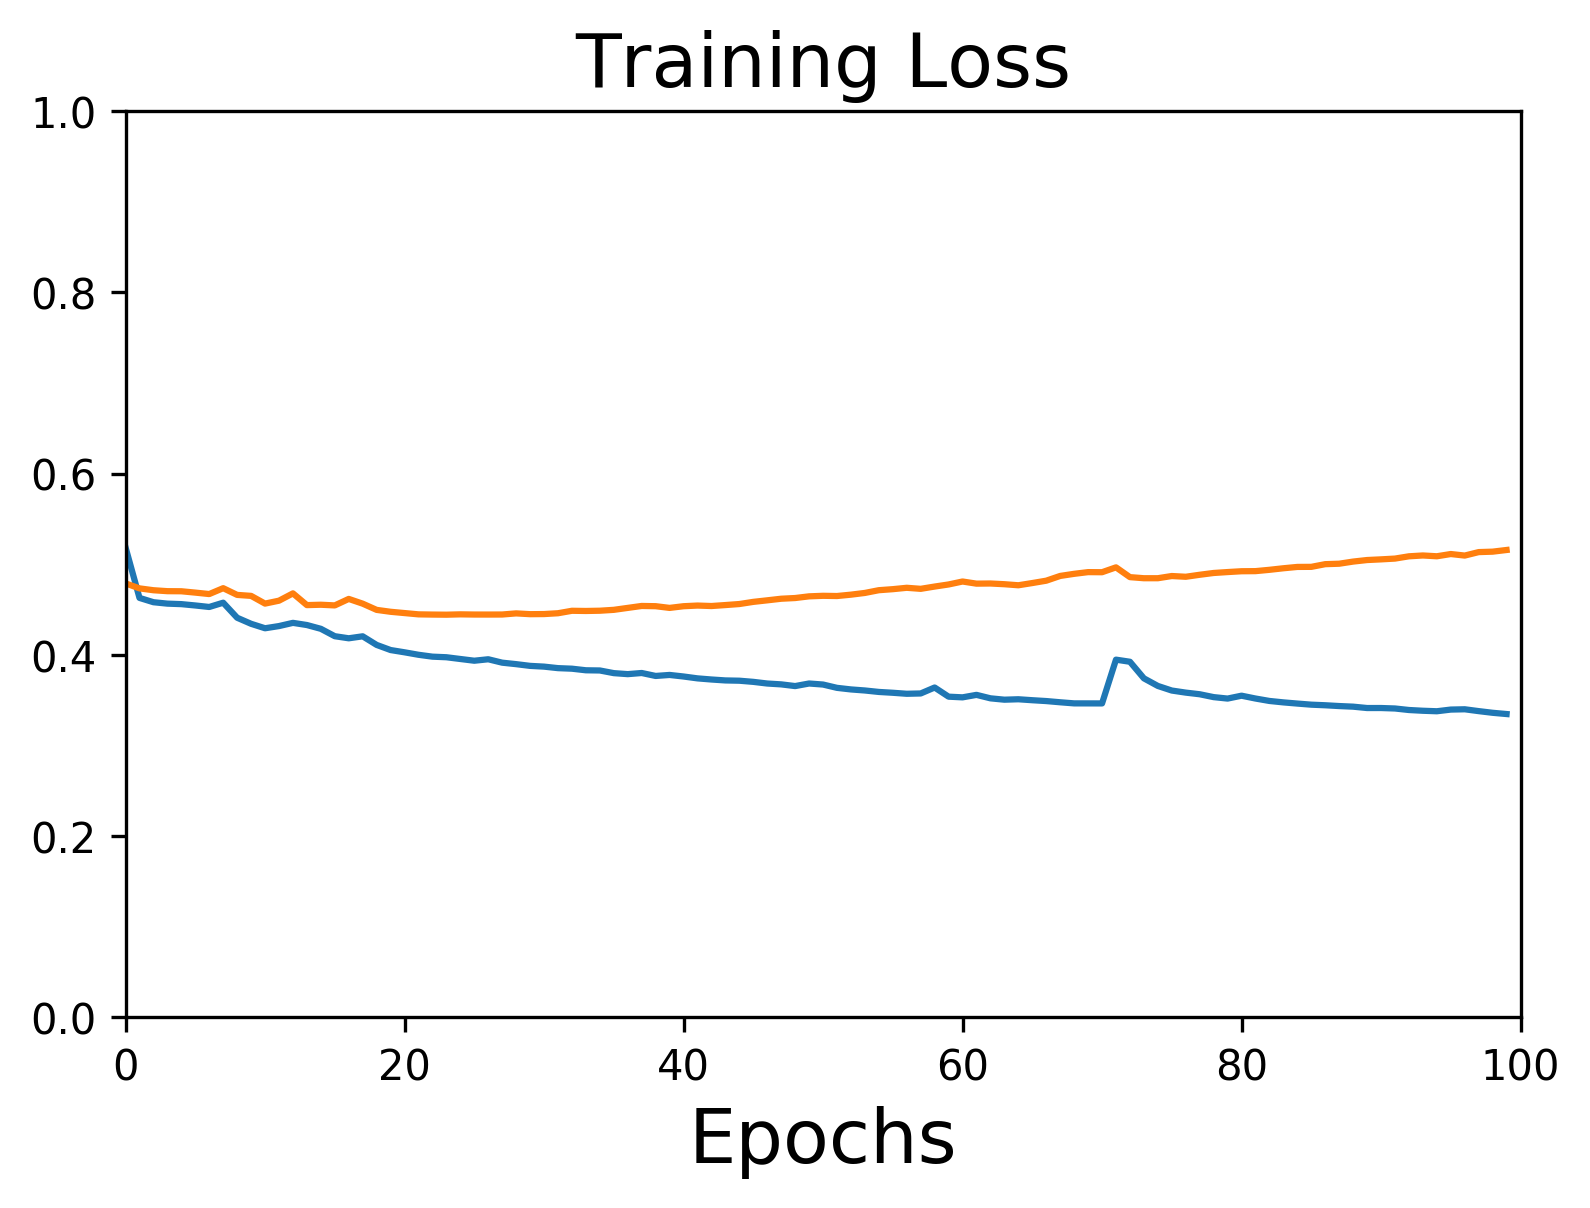

In [103]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, epochAvgLoss)
plt.plot(x, epochAvgLossValid)
plt.axis([0, epochPredictions.shape[0], 0, 1.0])
plt.title('Training Loss', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
plt.show()


In [163]:
prec = metrics.precision_score(y_pred = preds[nEpochs-1,:,:], y_true= yDev, average = 'samples')
rec = metrics.recall_score(y_pred = preds[nEpochs-1,:,:], y_true= yDev, average = 'samples')
f1 = metrics.f1_score(y_pred = preds[nEpochs-1,:,:], y_true= yDev, average = 'samples')
print('Precsion score averaged over samples %3f'%(prec))
print('Recall score averaged over samples %3f'%(rec))
print('F1 score averaged over samples %3f'%(f1))

Precsion score averaged over samples 0.299108
Recall score averaged over samples 0.262877
F1 score averaged over samples 0.265989


/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/oliver/anaconda3/envs/clinicalNoteTagger/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


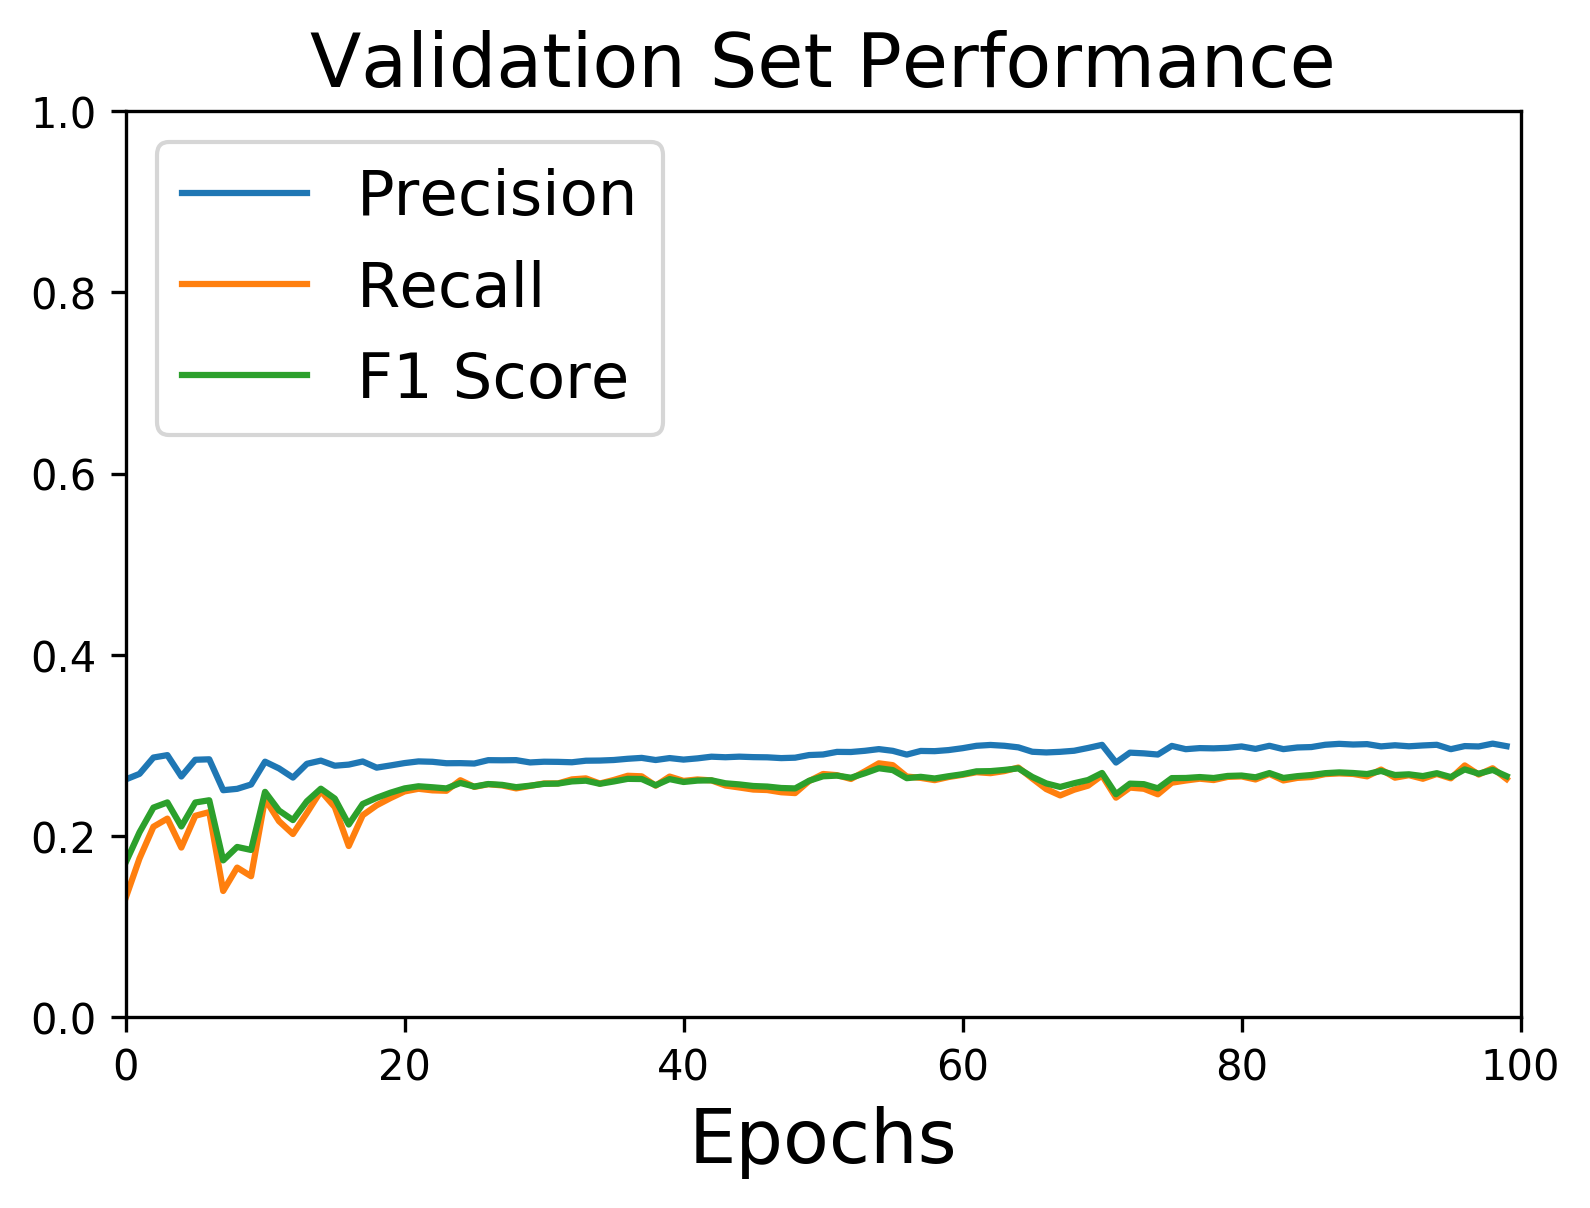

In [119]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, precOverEpoch)
plt.plot(x, recOverEpoch)
plt.plot(x, f1OverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Precision', 'Recall', 'F1 Score'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
plt.show()
# fig.savefig('src/plotting/resultPlotting/performance.png')

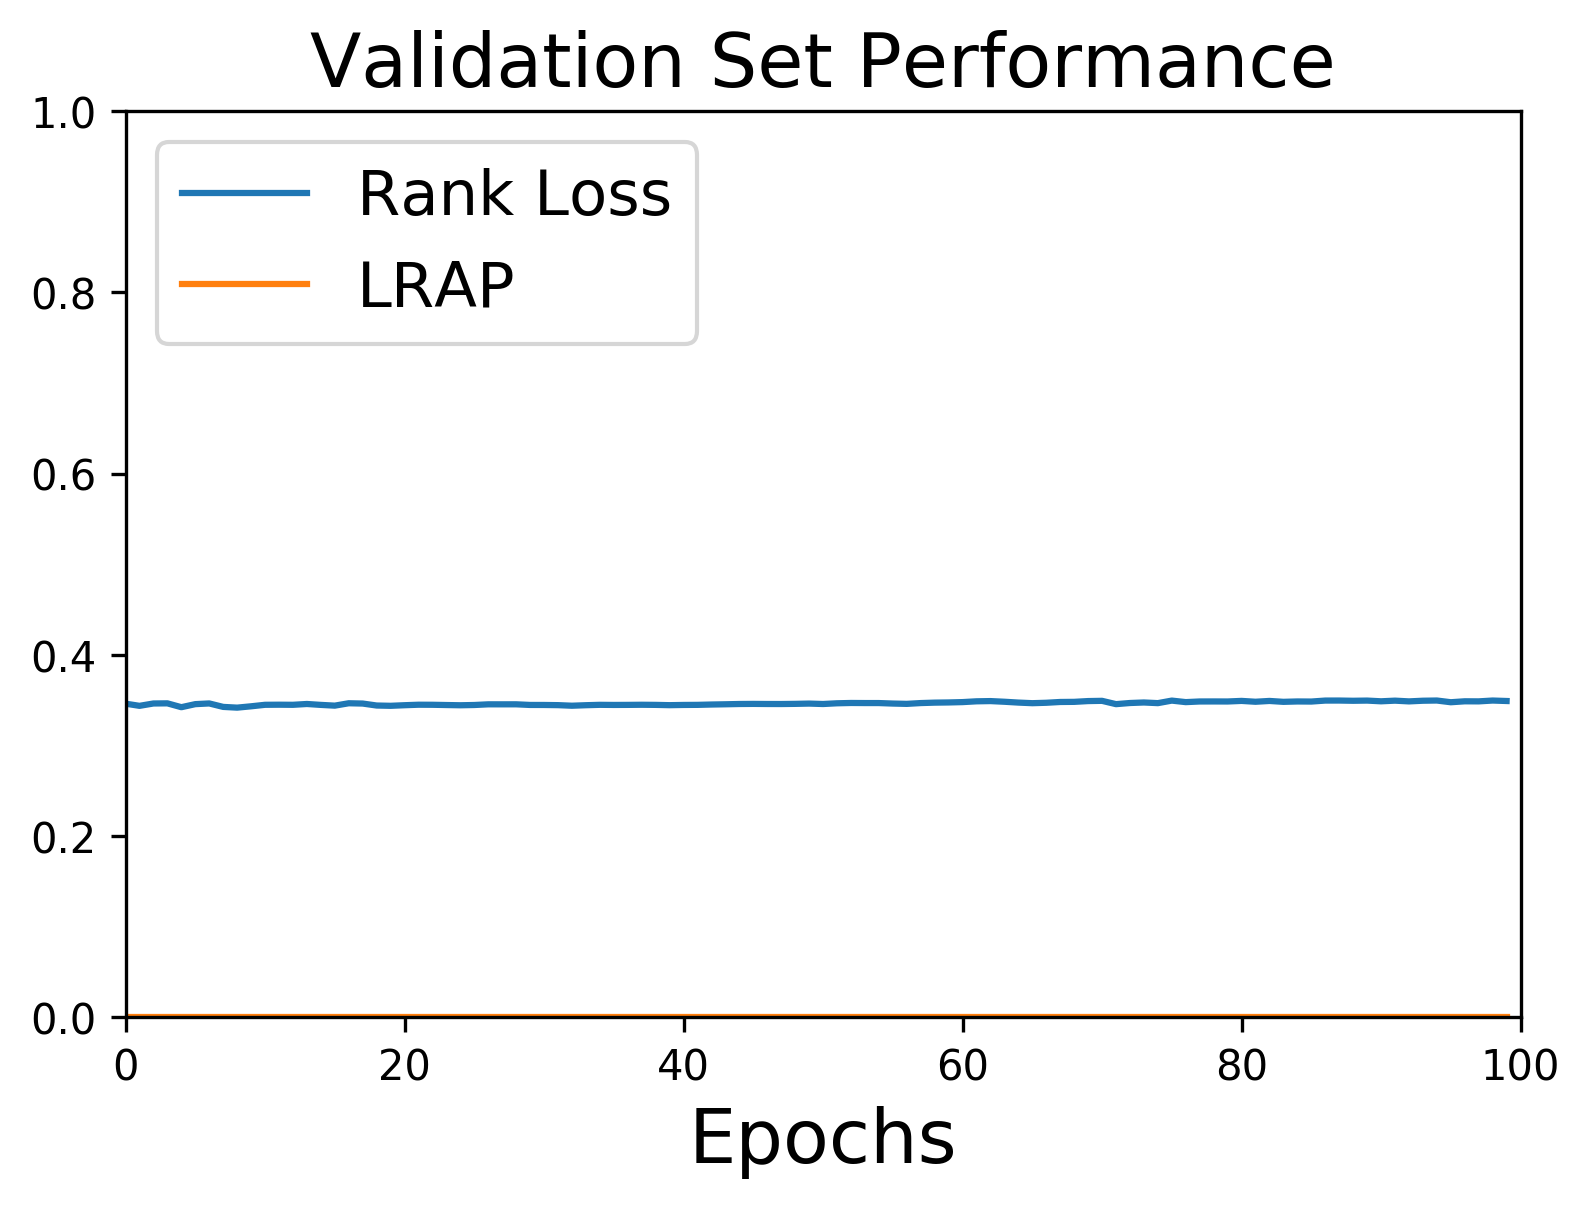

In [146]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, rankLossOverEpoch)
plt.plot(x, lrapOverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Rank Loss', 'LRAP'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
plt.show()

The mean number of codes in the devSet is 6.698


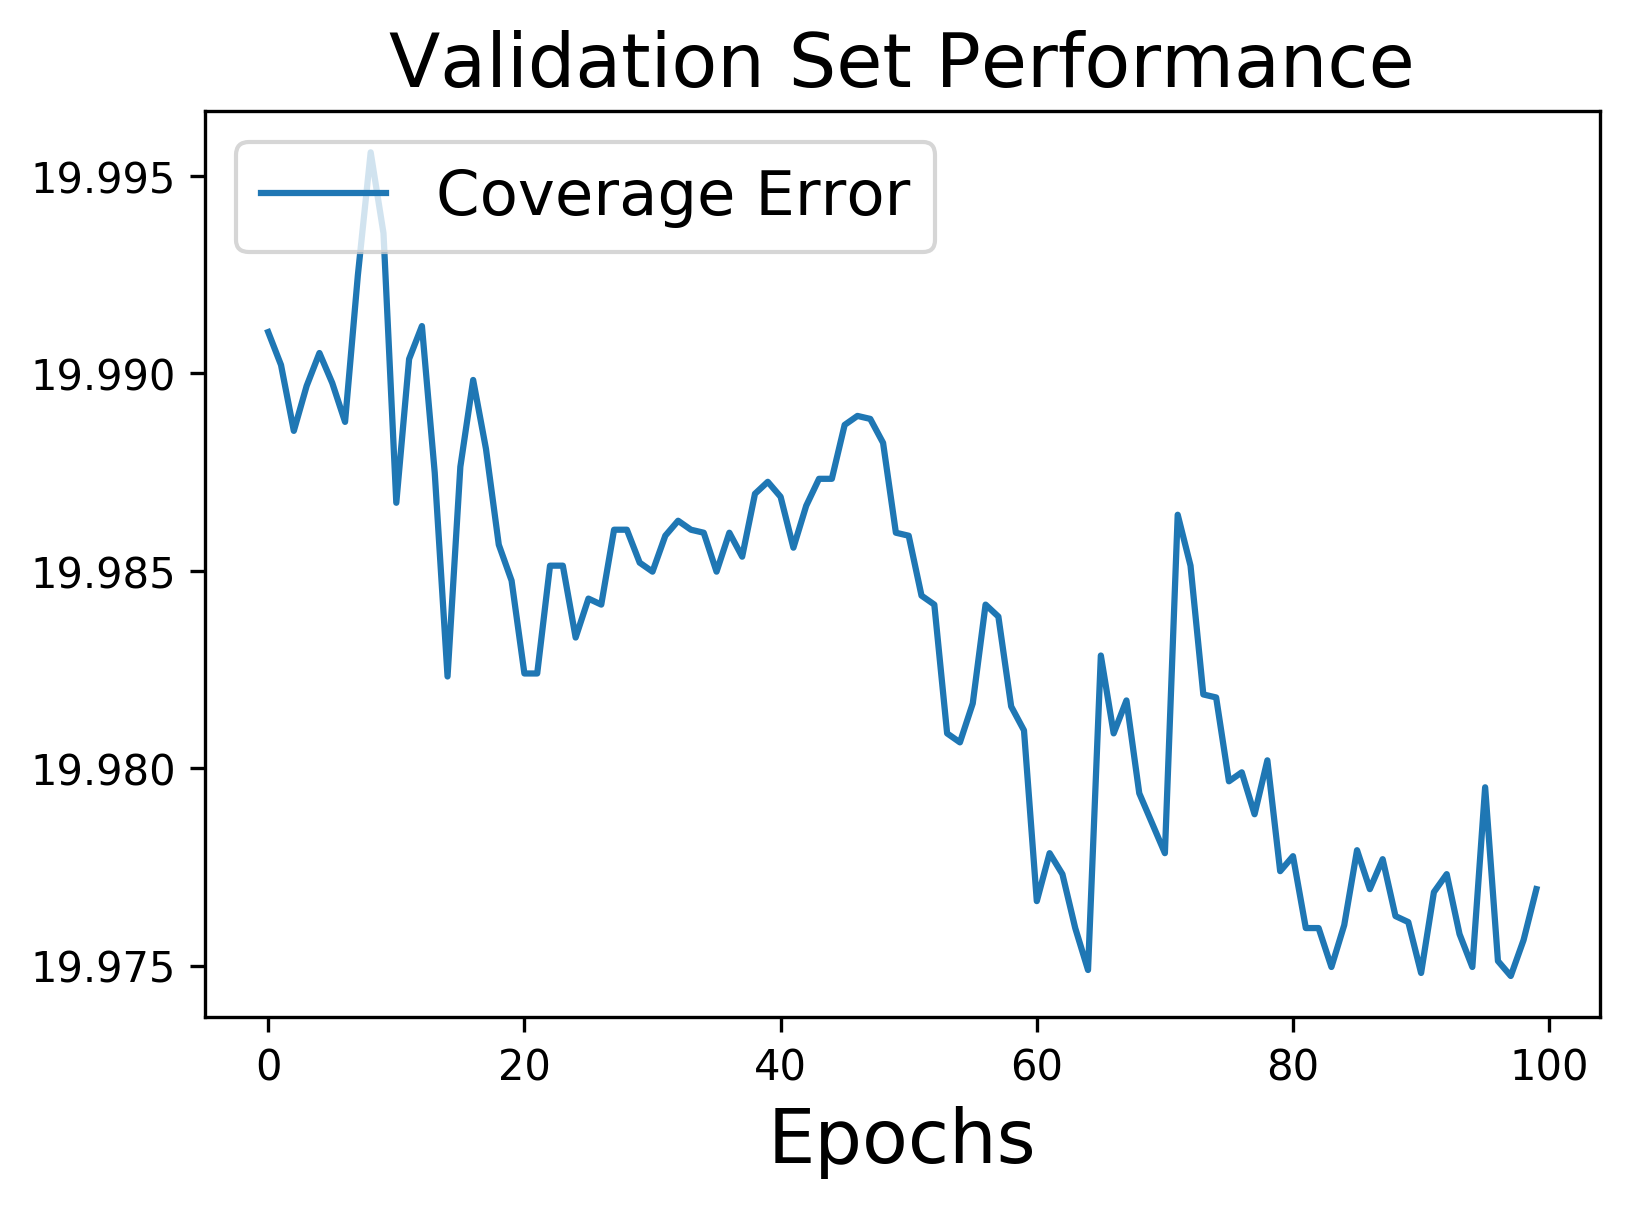

In [157]:
meanNumberOfCodes = np.sum(yDev, axis = 1)
meanNumberOfCodes = np.mean(meanNumberOfCodes)
print('The mean number of codes in the devSet is %.3f'%meanNumberOfCodes)
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, coverErrOverEpoch)

plt.legend(['Coverage Error'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
plt.show()